In [124]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn import preprocessing
from scipy.special import expit
import matplotlib.pyplot as plt
import scikitplot as skplt
import pandas as pd
import numpy as np

In [125]:
# Loading in data
data = pd.read_csv("inputsong3.csv")

# Delete non-number columns
data = data.drop(['Artist'], axis=1)
data = data.drop(['Album'], axis=1)
data = data.drop(['Track ID'], axis=1)
data = data.drop(['Track'], axis=1)

In [126]:
# Mapping Keys to numbers
key_di = {0: "C",0: "B#", 1: "C#", 2: "D", 3: "D#", 4: "E", 5: "F", 5: "E#", 6: "F#", 
          7: "G", 8: "G#", 9: "A", 10: "A#", 11: "B"}
data.replace({"Key": key_di})
data = data.drop(['Key'], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Release Date,Popularity,Danceability,Energy,Key Val,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,2014,43,0.388,0.9930,8,-2.863,1,0.1380,0.00424,0.000037,0.2740,0.0533,140.468,4
1,1966,6,0.255,0.3280,5,-11.156,0,0.0307,0.91200,0.000292,0.1080,0.1710,109.746,4
2,1983,16,0.472,0.0466,0,-20.043,1,0.0313,0.96900,0.489000,0.1110,0.0961,99.714,3
3,1977,15,0.582,0.8540,9,-7.964,1,0.0551,0.10900,0.245000,0.0917,0.8580,108.458,4
4,1956,0,0.699,0.1960,10,-20.424,1,0.1080,0.94400,0.000000,0.0860,0.7850,113.841,4


In [127]:
data.sort_values(['Popularity'],ascending=False).groupby('Popularity').count()

,Release Date,Danceability,Energy,Key Val,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
Popularity,,,,,,,,,,,,,
0,2140,2140,2140,2140,2140,2140,2140,2140,2140,2140,2140,2140,2140
1,1173,1173,1173,1173,1173,1173,1173,1173,1173,1173,1173,1173,1173
2,1198,1198,1198,1198,1198,1198,1198,1198,1198,1198,1198,1198,1198
3,1189,1189,1189,1189,1189,1189,1189,1189,1189,1189,1189,1189,1189
4,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163,1163
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,2,2,2,2,2,2,2,2,2,2,2,2,2
90,2,2,2,2,2,2,2,2,2,2,2,2,2
93,1,1,1,1,1,1,1,1,1,1,1,1,1


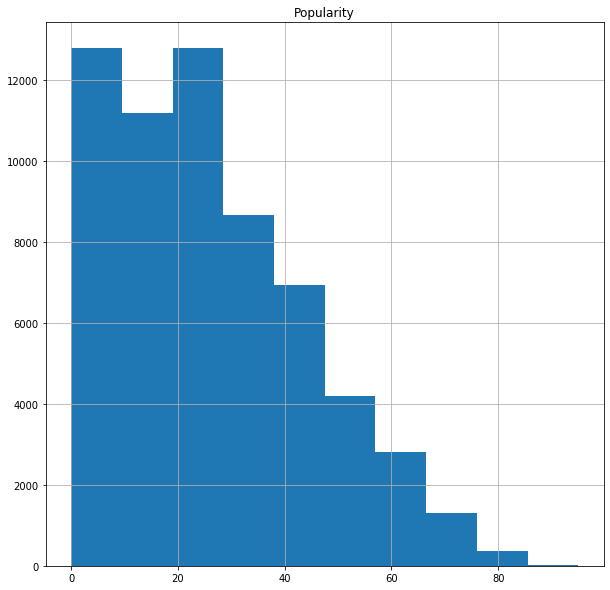

In [128]:
# check the distribution of popularity
hist = data.hist(column="Popularity", figsize = (10,10))

In [129]:
#normalize the data 
min_max_scaler = preprocessing.MinMaxScaler()
norm_data = min_max_scaler.fit_transform(data)
print(norm_data[:2])

[[9.50413223e-01 4.52631579e-01 3.93110436e-01 9.93000000e-01
  7.27272727e-01 8.96351029e-01 1.00000000e+00 1.42857143e-01
  4.25702811e-03 3.72745491e-05 2.74000000e-01 5.35140562e-02
  5.87990540e-01 8.00000000e-01]
 [5.53719008e-01 6.31578947e-02 2.58358663e-01 3.28000000e-01
  4.54545455e-01 7.66252510e-01 0.00000000e+00 3.17805383e-02
  9.15662651e-01 2.92585170e-04 1.08000000e-01 1.71686747e-01
  4.59390109e-01 8.00000000e-01]]


In [130]:
# Split training, testing, validation data by 80%, 10%, 10%
train_data, validate_data, test_data = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])

In [131]:
# Split output and convert to array
train_output = train_data.Popularity
train_data = train_data.drop(['Popularity'], axis=1)
train_data = np.asarray(train_data,dtype=np.float64)
training_count = len(train_data[:,0])

validate_output = validate_data.Popularity
validate_data = validate_data.drop(['Popularity'], axis=1)
validate_data = np.asarray(validate_data,dtype=np.float64)
validate_count = len(validate_data[:,0])

test_output = test_data.Popularity
test_data = test_data.drop(['Popularity'], axis=1)
test_data = np.asarray(test_data,dtype=np.float64)
test_count = len(test_data[:,0])

In [132]:
#class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), 
# activation='relu', solver='adam', alpha=0.0001, batch_size='auto', 
# learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, 
# shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, 
# momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, 
# beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

mlp = MLPClassifier(hidden_layer_sizes=(14, 8,),solver='adam', activation='logistic',max_iter=1000)
mlp.fit(train_data,train_output)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(14, 8), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [133]:
test_pred = mlp.predict(test_data)
print(test_pred[:20])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [134]:
valid_pred = mlp.predict(validate_data)
print(valid_pred[:20])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [135]:
print("Training set score: {}".format(mlp.score(train_data,train_output)))

Training set score: 0.03554827480290775


In [136]:
print("Testing set score: {}".format(mlp.score(test_data,test_output)))

Testing set score: 0.033906633906633905


In [137]:
print("Validation set score: {}".format(mlp.score(validate_data,validate_output)))

Validation set score: 0.03227391874180865


In [138]:
#probability to each label
print("Distribution of probability on validation set: {}".format(mlp.predict_proba(validate_data[:1])))

Distribution of probability on validation set: [[3.57974639e-02 1.87216602e-02 1.98324512e-02 1.97392888e-02
  1.87602717e-02 1.89100494e-02 1.90960119e-02 2.00687749e-02
  1.91586351e-02 1.81881229e-02 1.91389642e-02 1.99999145e-02
  2.25108088e-02 1.92915366e-02 2.02621072e-02 2.07749956e-02
  1.86103965e-02 2.02445833e-02 2.30900181e-02 2.36540716e-02
  2.10735599e-02 2.32943807e-02 2.16368675e-02 2.14496378e-02
  1.92338223e-02 2.00568147e-02 2.04811257e-02 1.88948361e-02
  1.86289464e-02 1.73625539e-02 1.79354663e-02 1.49024061e-02
  1.69111499e-02 1.60263210e-02 1.48664673e-02 1.51814932e-02
  1.40538922e-02 1.32242113e-02 1.28851077e-02 1.33316354e-02
  1.21665154e-02 1.29238623e-02 1.27633833e-02 1.17762566e-02
  1.07265009e-02 1.05627205e-02 9.49090697e-03 1.00316427e-02
  9.32626296e-03 8.47083407e-03 8.59051755e-03 8.64365025e-03
  7.07937508e-03 7.58526775e-03 6.82210881e-03 6.27321135e-03
  5.85305784e-03 5.76184368e-03 5.26556908e-03 5.17039974e-03
  5.37061132e-03 4.4825

In [139]:
print(classification_report(train_output,mlp.predict(train_data)))

              precision    recall  f1-score   support

           0       0.04      1.00      0.07      1736
           1       0.00      0.00      0.00       945
           2       0.00      0.00      0.00       980
           3       0.00      0.00      0.00       960
           4       0.00      0.00      0.00       931
           5       0.00      0.00      0.00       934
           6       0.00      0.00      0.00       950
           7       0.00      0.00      0.00       962
           8       0.00      0.00      0.00       931
           9       0.00      0.00      0.00       958
          10       0.00      0.00      0.00       944
          11       0.00      0.00      0.00       941
          12       0.00      0.00      0.00      1042
          13       0.00      0.00      0.00       937
          14       0.00      0.00      0.00       980
          15       0.00      0.00      0.00       982
          16       0.00      0.00      0.00       912
          17       0.00    

/Users/lin_peihsuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [140]:
print("accuracy score of training: {}".format(accuracy_score(train_output,mlp.predict(train_data))))
print("accuracy score of testing: {}".format(accuracy_score(test_output,mlp.predict(test_data))))
print("accuracy score of validating: {}".format(accuracy_score(validate_output,mlp.predict(validate_data))))

accuracy score of training: 0.03554827480290775
accuracy score of testing: 0.033906633906633905
accuracy score of validating: 0.03227391874180865


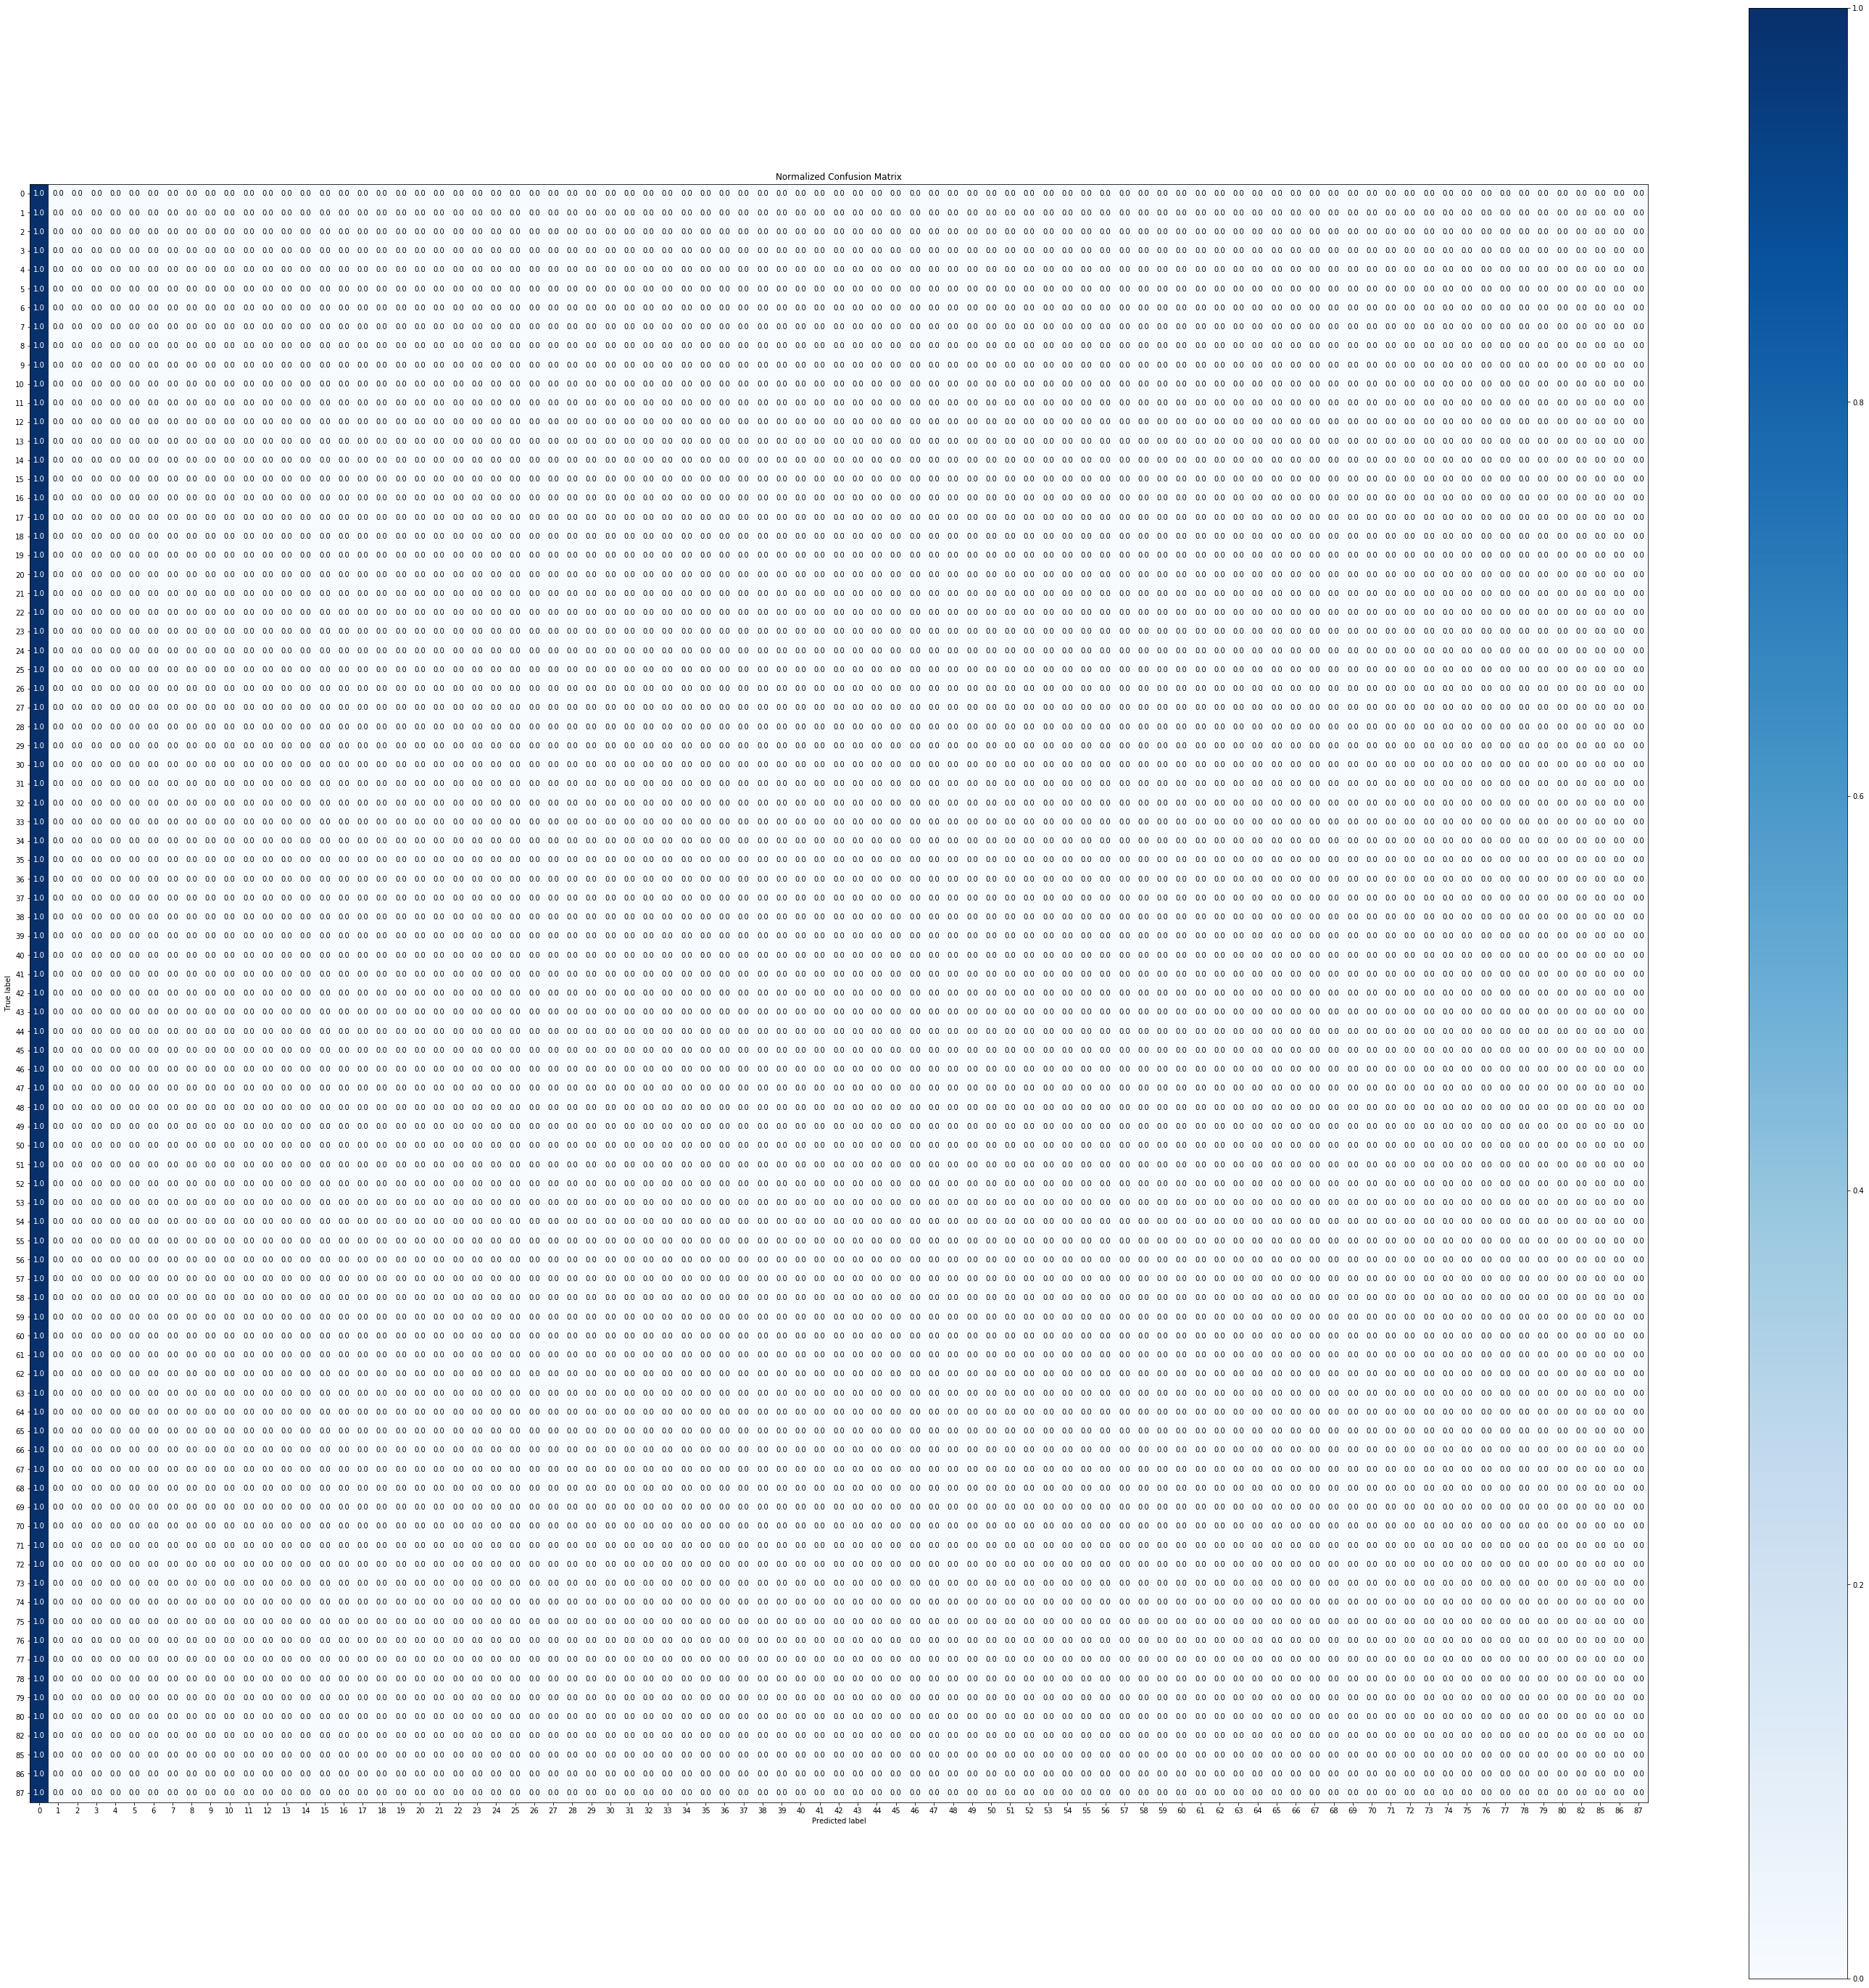

In [141]:
skplt.metrics.plot_confusion_matrix(validate_output, valid_pred, normalize=True, figsize=(50,50))